### **HOMEWORK 2**  <h3>

### **Exercício 1**  <h3>
#### **a)** <h4>

Inicialmente temos que ler o DataSet. 

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from scipy.stats import ttest_rel

# Reading the file
data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

De seguida, é necessário separar os dados em dois grupos: um para as features (variáveis de input) e outro para as classes (variáveis de output).

In [8]:
X = df.drop('class', axis=1) 
y = df['class'] 

De seguida, fizémos stratified cross-validation e inicializámos os classificadores kNN  (k=5) e Naive Bayes.

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

knn = KNeighborsClassifier(n_neighbors=5)
nb = GaussianNB()

In [10]:
scores_knn = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
scores_nb = cross_val_score(nb, X, y, cv=cv, scoring='accuracy')

scores_list = [scores_knn, scores_nb]

Fizemos os boxplots com as fold accuracies para os dois classificadores.

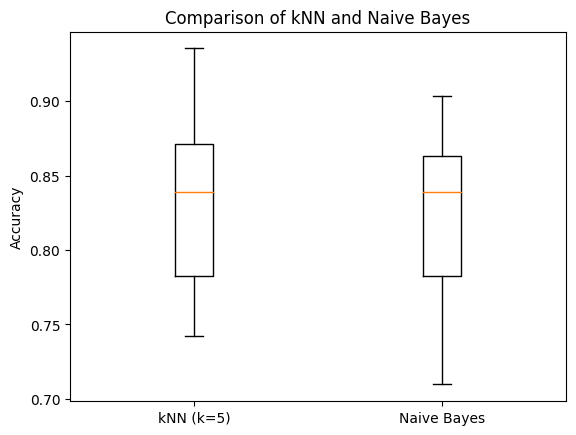

In [11]:
fig, ax = plt.subplots()

ax.boxplot(scores_list)
ax.set_xticklabels(['kNN (k=5)', 'Naive Bayes'])
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of kNN and Naive Bayes')
plt.show()

#### **b)** <h4>

Utilizámos o t-test para testar a hipótese de que kNN é estatisticamente superior a Naive Bayes relativamente à accuracy.

In [12]:
t_stat, p_value = ttest_rel(scores_knn, scores_nb, alternative='greater')

print('t-statistic:', t_stat)
print('p-value:', p_value)


t-statistic: 0.9214426752509264
p-value: 0.19042809062064092


Dado que o p-value é maior que 0.05, concluímos que a hipótese não é verdadeira.

### **Exercício 2**  <h3>

Inicializámos os classificadores kNN para k=1 e k=5.

In [13]:
knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

Obtivemos os y previstos para ambos.

In [14]:
knn1.fit(X, y)
knn5.fit(X, y)
y1_pred = knn1.predict(X)
y5_pred = knn5.predict(X)

Fizémos as matrizes de confusão e a diferença entre elas.

In [15]:
cm1 = confusion_matrix(y, y1_pred)
cm5 = confusion_matrix(y, y5_pred)

dif = cm1 - cm5

Fizémos o gráfico.

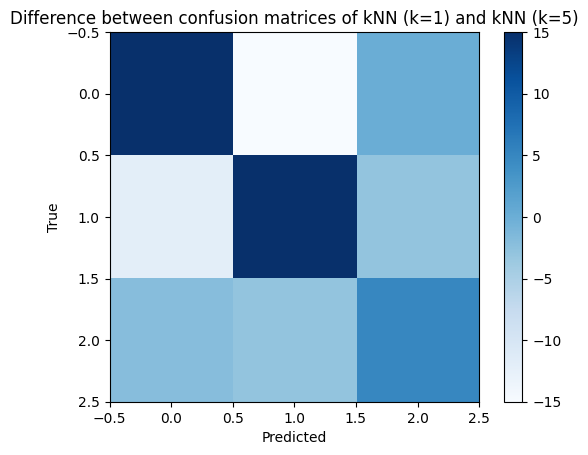

In [16]:
plt.figure()
plt.imshow(dif, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.yticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.title('Difference between confusion matrices of kNN (k=1) and kNN (k=5)')
plt.show()

### **Exercício 3**  <h3>